# Load Library

In [59]:
import logging
import os
import random
import re
import traceback
import warnings
from glob import glob
from pprint import pprint
from textwrap import dedent
from typing import Annotated, List, Literal, Optional, Tuple, TypedDict

import gradio as gr
from dotenv import load_dotenv
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

warnings.filterwarnings("ignore")

load_dotenv()

%reload_ext autotime

time: 0 ns (started: 2025-05-10 12:21:25 +09:00)


In [2]:
DATA_DIR = '../data'
PERSIST_DIR = "./chroma_db"

# 법률 이름 매핑 딕셔너리
LAW_NAME_MAPPING = {
    "고용보험법": "employment_insurance_act",
    "근로기준법": "labor_standards_act",
    "남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률": "gender_equality_employment_act",
}

time: 0 ns (started: 2025-05-10 10:38:02 +09:00)


# Define Function

In [3]:
def split_articles(lines):
    """
    조문 본문에서 개행으로 인한 단어 분리를 방지하기 위해
    줄 간 공백 없이 연결한다. 조문은 '제X조(제목)' 형식으로 시작한다.
    """
    # 조문을 저장할 리스트
    articles = []
    # 현재 처리 중인 조문의 제목
    current_title = None  
    # 현재 처리 중인 조문의 내용
    current_content = []

    # '제X조(제목)' 형식을 찾기 위한 정규표현식 패턴
    title_pattern = re.compile(r'^(제\d+조(?:의\d+)?\([^)]+\))')

    # 각 줄을 순회하며 처리
    for line in map(str.strip, lines):
        if not line:  # 빈 줄 건너뛰기
            continue

        # 조문 제목 패턴이 매칭되는지 확인
        match = title_pattern.match(line)
        if match:
            # 이전 조문이 있으면 저장
            if current_title:
                articles.append(f"{current_title}\n{''.join(current_content)}")
            # 새로운 조문 시작
            current_title = match.group(1)
            rest = line[len(current_title):].strip()
            current_content = [rest] if rest else []
        elif current_title:
            # 조문 내용 추가
            current_content.append(line)

    # 마지막 조문 저장
    if current_title:
        articles.append(f"{current_title}\n{''.join(current_content)}")

    return [a.strip() for a in articles]

def parse_law_with_sections(law_text):
    """
    전체 법령 텍스트를 서문, 장, 절, 조문 단위로 구조화하여 파싱한다.
    """
    # 줄바꿈 문자 정규화
    law_text = law_text.replace('\r\n', '\n').replace('\r', '\n')
    lines = map(str.strip, law_text.split('\n'))

    # 파싱 결과를 저장할 딕셔너리
    parsed_law = {'서문': '', '장': {}, '부칙': ''}
    
    # 장과 절을 찾기 위한 정규표현식 패턴
    chapter_pattern = re.compile(r'^제\d+장\s+\S+')
    section_pattern = re.compile(r'^제\d+절\s+\S+')

    # 현재 처리 중인 위치 추적용 변수들
    current_chapter = None
    current_section = None
    chapter_buffer = {}
    buffer = []
    preamble_done = False

    # 각 줄을 순회하며 처리
    for i, line in enumerate(lines):
        if not line:
            continue

        # 부칙 처리
        if line.startswith("부칙"):
            if current_section:
                chapter_buffer[current_section] = buffer
            elif buffer:
                chapter_buffer['조문'] = buffer
            if current_chapter:
                parsed_law['장'][current_chapter] = {
                    k: split_articles(v) for k, v in chapter_buffer.items()
                }
            parsed_law['부칙'] = '\n'.join([line] + list(lines)[i+1:]).strip()
            break

        # 장 처리
        if chapter_pattern.match(line):
            if not preamble_done:
                parsed_law['서문'] = '\n'.join(buffer).strip()
                preamble_done = True
            elif current_chapter:
                if current_section:
                    chapter_buffer[current_section] = buffer
                elif buffer:
                    chapter_buffer['조문'] = buffer
                parsed_law['장'][current_chapter] = {
                    k: split_articles(v) for k, v in chapter_buffer.items()
                }
            current_chapter = line
            chapter_buffer = {}
            current_section = None
            buffer = []
            continue

        # 절 처리
        if section_pattern.match(line):
            if current_section:
                chapter_buffer[current_section] = buffer
            elif buffer:
                chapter_buffer['조문'] = buffer
            current_section = line
            buffer = []
            continue

        buffer.append(line)

    # 마지막 장 저장
    if current_chapter:
        if current_section:
            chapter_buffer[current_section] = buffer
        elif buffer:
            chapter_buffer['조문'] = buffer
        parsed_law['장'][current_chapter] = {
            k: split_articles(v) for k, v in chapter_buffer.items()
        }

    return parsed_law


def create_document(pdf_file: str, law_name: str) -> List[Document]:
    loader = PyPDFLoader(pdf_file)
    pages = loader.load()
    
    # 푸터 제거용 패턴
    footer_pattern = rf"법제처\s+\d+\s+국가법령정보센터\s*\n{law_name}"
    re_footer = re.compile(footer_pattern)
    
    # 각 페이지에서 푸터 제거
    cleaned_pages = []
    for p in pages:
        text = p.page_content.strip()
        cleaned = re_footer.sub('', text)
        cleaned_pages.append(cleaned.strip())
        
    # 전체 문서 텍스트 결합
    law_text = "\n".join(cleaned_pages)
    
    parsed_law = parse_law_with_sections(law_text)
    
    # Document 객체로 만들기
    final_docs = []
    
    for chapter, sections in parsed_law["장"].items():
        for section, articles in sections.items():
            for article_text in articles:
                # 조문 제목 줄 (예: "제1조(목적)")
                title_line = article_text.split("\n", 1)[0]
                
                # LangChain 문서 metadata 구성
                metadata = {
                    "source": pdf_file,
                    "chapter": chapter,
                    "section": section,
                    "name": law_name,
                    "article": title_line
                }
                
                # LangChain 문서 본문 구성
                content = (
                    f"[법률정보]\n"
                    f"다음 조항은 {metadata['name']} {metadata['chapter']} {metadata['section']}에서 발췌한 내용입니다.\n\n[법률조항]\n"
                    f"{article_text}"
                )

                final_docs.append(Document(page_content=content, metadata=metadata))
                
    return final_docs

time: 0 ns (started: 2025-05-10 10:38:02 +09:00)


# Load Raw Documents

In [4]:
# pdf 파일 목록을 확인
pdf_files = glob(os.path.join(DATA_DIR, '*.pdf'))

pdf_files

['../data\\고용보험법(법률)(제20519호)(20250223).pdf',
 '../data\\근로기준법(법률)(제20520호)(20250223).pdf',
 '../data\\남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률(법률)(제20521호)(20250223).pdf']

time: 15 ms (started: 2025-05-10 10:38:03 +09:00)


# Create VectorDB

In [5]:
embeddings = OpenAIEmbeddings()

for idx, (law_name, collection_name) in enumerate(LAW_NAME_MAPPING.items()):
    final_documents = create_document(pdf_file=pdf_files[idx], law_name=law_name)
    
    Chroma.from_documents(
        documents=final_documents,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=PERSIST_DIR
    )
    

time: 20.5 s (started: 2025-05-10 10:38:03 +09:00)


# Define Tool

In [6]:
ei_db = Chroma(
    embedding_function=embeddings,
    collection_name=LAW_NAME_MAPPING.get("고용보험법"),
    persist_directory=PERSIST_DIR
)

ls_db = Chroma(
    embedding_function=embeddings,
    collection_name=LAW_NAME_MAPPING.get("근로기준법"),
    persist_directory=PERSIST_DIR
)

ge_db = Chroma(
    embedding_function=embeddings,
    collection_name=LAW_NAME_MAPPING.get("남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률"),
    persist_directory=PERSIST_DIR
)

time: 547 ms (started: 2025-05-10 10:38:23 +09:00)


In [7]:
@tool
def search_ei_law(query: str) -> List[Document]:
    """
    Searches the Employment Insurance Act (고용보험법) database for relevant legal articles.

    Args:
        query (str): A keyword or phrase related to the Employment Insurance Act to search for.

    Returns:
        List[Document]: 
            - A list of Document objects containing the most relevant sections.
            - If no matching articles are found, returns a Document indicating "검색 결과가 없습니다."

    Usage:
        Use this tool when you need to retrieve legal information, specific clauses, 
        or general background knowledge about the Employment Insurance Act.
    """
    docs = ei_db.similarity_search(query, k=2)
    return docs if docs else [Document(page_content="", metadata={"error": "검색 결과가 없습니다."})]

@tool
def search_ls_law(query: str) -> List[Document]:
    """
    Searches the Labor Standards Act (근로기준법) database for relevant legal articles.

    Args:
        query (str): A keyword or phrase related to the Labor Standards Act to search for.

    Returns:
        List[Document]: 
            - A list of Document objects containing the most relevant sections.
            - If no matching articles are found, returns a Document indicating "검색 결과가 없습니다."

    Usage:
        Use this tool when you need to retrieve legal information, specific clauses, 
        or general background knowledge about the Labor Standards Act.
    """
    docs = ls_db.similarity_search(query, k=2)
    return docs if docs else [Document(page_content="", metadata={"error": "검색 결과가 없습니다."})]

@tool
def search_ge_law(query: str) -> List[Document]:
    """
    Searches the Gender Equality Employment Act 
    (남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률) database for relevant legal articles.

    Args:
        query (str): A keyword or phrase related to the Gender Equality Employment Act to search for.

    Returns:
        List[Document]: 
            - A list of Document objects containing the most relevant sections.
            - If no matching articles are found, returns a Document indicating "검색 결과가 없습니다."

    Usage:
        Use this tool when you need to retrieve legal information, specific clauses, 
        or general background knowledge about the Gender Equality Employment Act.
    """
    docs = ge_db.similarity_search(query, k=2)
    return docs if docs else [Document(page_content="", metadata={"error": "검색 결과가 없습니다."})]

time: 15 ms (started: 2025-05-10 10:38:24 +09:00)


# LangChain Agent

In [8]:
agent_prompt = ChatPromptTemplate.from_messages([
    ("system", dedent("""You are an AI legal assistant specializing in Korean labor-related laws.
                      Your primary mission is to provide users with accurate, reliable, and contextually appropriate legal information based on three major legislations.
                      
                      Key guidelines:
                      1. For questions related to general labor rights, working conditions, employment contracts, wages, working hours, minimum wage, and termination procedures, use the search_ls_law tool.
                        - Related keywords: "근로시간", "연장근로", "임금", "최저임금", "해고", "취업규칙", "연차휴가", "근로계약서", "퇴직금"
                        - This tool accesses the Labor Standards Act (근로기준법).
                      2. For questions regarding unemployment benefits, employment insurance enrollment, premium payments, claims, eligibility, and job protection during unemployment, use the search_ei_law tool.
                        - Related keywords: "실업급여", "고용보험", "피보험자", "보험료", "이직확인서", "재취업활동"
                        - This tool accesses the Employment Insurance Act (고용보험법).
                      3. For questions involving gender equality at work, maternity and paternity leave, prevention of workplace discrimination, childcare leave, and work-family balance policies, use the search_ge_law tool.
                        - Related keywords: "출산휴가", "육아휴직", "남녀차별", "임신기 근로시간 단축", "배우자 출산휴가", "가족돌봄휴가", "직장 내 성희롱 예방"
                        - This tool accesses the Gender Equality Employment Act (남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률).
                      4. If a user's query is ambiguous or covers multiple topics (e.g., "육아휴직 중 실업급여 수급 가능 여부"), intelligently select multiple tools, retrieve information from each relevant law, and combine the results into a coherent answer.
                      5. If necessary information is missing, politely ask the user to clarify their question to ensure correct tool usage.
                      6. Always prioritize delivering clear, concise, and legally accurate information based on the search results.
                      7. Simplify legal jargon into plain, user-friendly language unless the user specifically requests detailed legal references.
                      8. Maintain a professional, supportive, and trustworthy tone. Users may be seeking crucial legal guidance, so be respectful, empathetic, and clear.
                      9. If no relevant documents are found in the database, explicitly inform the user and suggest further actions if appropriate.
                      10. Ensure final responses are natural and conversational, maintaining a helpful chatbot-like communication style while retaining professional accuracy.
                      
                      Remember:
                        - Understand the scope of each tool precisely.
                        - Match the user's query keywords to the right tool(s).
                        - Combine tool results effectively for complex questions.
                        - Always aim to deliver the most complete, accurate, and user-centered answers possible.
                    """)),
    MessagesPlaceholder(variable_name="chat_history", optional=True),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

time: 16 ms (started: 2025-05-10 10:38:24 +09:00)


In [9]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

tools = [search_ls_law, search_ei_law, search_ge_law]
agent = create_tool_calling_agent(llm, tools, agent_prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

time: 1.92 s (started: 2025-05-10 10:38:24 +09:00)


In [10]:
query = "육아휴직을 신청할 수 있는 조건이 있나요?"
agent_response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `search_ge_law` with `{'query': '육아휴직'}`


[Document(metadata={'article': '제19조의6(직장복귀를 위한 사업주의 지원)', 'chapter': '제3장 모성 보호 <개정 2007. 12. 21.>', 'name': '남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률', 'section': '조문', 'source': '../data\\남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률(법률)(제20521호)(20250223).pdf'}, page_content='[법률정보]\n다음 조항은 남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률 제3장 모성 보호 <개정 2007. 12. 21.> 조문에서 발췌한 내용입니다.\n\n[법률조항]\n제19조의6(직장복귀를 위한 사업주의 지원)\n사업주는 이 법에 따라 육아휴직 중인 근로자에 대한 직업능력 개발 및 향상을 위하여 노력하여야 하고 출산전후휴가, 육아휴직 또는 육아기 근로시간 단축을 마치고 복귀하는 근로자가 쉽게직장생활에 적응할 수 있도록 지원하여야 한다. <개정 2012. 2. 1.>[본조신설 2007. 12. 21.]'), Document(metadata={'article': '제19조의6(직장복귀를 위한 사업주의 지원)', 'chapter': '제3장 모성 보호 <개정 2007. 12. 21.>', 'name': '남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률', 'section': '조문', 'source': '../data\\남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률(법률)(제20521호)(20250223).pdf'}, page_content='[법률정보]\n다음 조항은 남녀고용평등과 일ㆍ가정 양립 지원에 관한 법률 제3장 모성 보호 <개정 2007. 12. 21.> 조문에서 발췌한 내용입니다.\n\n[법률조항]\n제19조의6(직장복귀를 위한 사업주의 지원)\n사업

In [11]:
pprint(agent_response)

{'input': '육아휴직을 신청할 수 있는 조건이 있나요?',
 'output': '육아휴직을 신청할 수 있는 조건은 다음과 같습니다:\n'
           '\n'
           '1. **근로자 자격**: 육아휴직은 근로자가 자녀를 양육하기 위해 신청할 수 있는 권리입니다. 일반적으로, 자녀가 만 '
           '8세 이하이거나 초등학교 2학년 이하인 경우에 해당합니다.\n'
           '\n'
           '2. **근속 기간**: 육아휴직을 신청하기 위해서는 일정 기간 이상 근무해야 할 수 있습니다. 보통 6개월 이상의 '
           '근속이 요구됩니다.\n'
           '\n'
           '3. **신청 절차**: 육아휴직을 신청하려면, 고용주에게 사전에 신청서를 제출해야 하며, 필요한 서류를 함께 제출해야 '
           '합니다.\n'
           '\n'
           '4. **사업주의 지원**: 사업주는 육아휴직 중인 근로자가 직장에 복귀할 수 있도록 지원해야 하며, 직업능력 개발 및 '
           '향상을 위한 노력을 해야 합니다.\n'
           '\n'
           '이 외에도 구체적인 조건이나 절차는 고용주나 회사의 취업규칙에 따라 다를 수 있으므로, 해당 사항을 확인하는 것이 '
           '중요합니다. 추가적인 질문이 있으시면 언제든지 말씀해 주세요!'}
time: 16 ms (started: 2025-05-10 10:38:33 +09:00)


# Corrective RAG

In [62]:
class CorrectiveRAGState(BaseModel):
    """Base State model for Corrective RAG flow."""

    question: str = Field(..., description="The user's original question.")
    # generation: str = Field(default="", description="The current generated answer.")
    relevant_docs: List[Document] = Field(default_factory=list, description="Documents retrieved from the database.")
    num_generations: int = Field(default=0, ge=0, le=1, description="Number of generations attempted.")

    class Config:
        arbitrary_types_allowed = True

class InformationItem(BaseModel):
    content: str = Field(..., description="Extracted information content.")
    source: str = Field(..., description="Source of the information.")
    relevance_score: float = Field(..., description="Relevance score between 0 and 1.")
    faithfulness_score: float = Field(..., description="Faithfulness score between 0 and 1.")

class ExtractedInformation(BaseModel):
    strips: List[InformationItem] = Field(..., description="List of extracted information items.")
    query_relevance: float = Field(..., description="Overall confidence score between 0 and 1.")


class RefinedQuestion(BaseModel):
    """Refined user question with justification."""
    question_refined: str = Field(..., description="Refined version of the original question.")
    reason: str = Field(..., description="Explanation why the question was refined.")

time: 32 ms (started: 2025-05-10 12:23:40 +09:00)


## 고용보험법

In [63]:
class EmploymentInsuranceState(CorrectiveRAGState):
    """
    State model for Employment Insurance Information retrieval and response generation.
    Inherits base Corrective RAG state and adds additional fields specific to this workflow.
    """
    
    rewritten_question: str = Field(
        default="",
        description="The rewritten version of the user's original question, if applicable."
    )
    extracted_info: Optional[ExtractedInformation] = Field(
        default=None,
        description="The structured information extracted from the knowledge base relevant to the question."
    )
    final_answer: Optional[str] = Field(
        default=None,
        description="The response generated by the node model based on retrieved documents."
    )

time: 0 ns (started: 2025-05-10 12:23:41 +09:00)


In [64]:
logger = logging.getLogger(__name__)

def retrieve_documents(state: EmploymentInsuranceState) -> dict:
    print("[Employment Insurance RAG] Retrieving documents...")
    logger.info("[Employment Insurance RAG] Retrieving documents...")
    query = state.rewritten_question or state.question
    docs = search_ei_law.invoke(query)
    return {"relevant_docs": docs}

def extract_and_evaluate_information(state: EmploymentInsuranceState) -> dict:
    print("[Employment Insurance RAG] Extracting and evaluating information...")
    logger.info("[Employment Insurance RAG] Extracting and evaluating information...")
    extracted_strips = []
    
    extract_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert on the Employment Insurance Act.  
        Review the provided document and extract 3 to 5 key facts or pieces of information related to the user's question.  
        For each extracted item, assign two scores between 0 and 1:

        1. Relevance: How closely the information answers the user's question.
        2. Faithfulness: How accurate and complete the information is in addressing the question.

        Output format example:
        1. [Extracted information]
        - Relevance score: [0-1]
        - Faithfulness score: [0-1]
        2. [Extracted information]
        - Relevance score: [0-1]
        - Faithfulness score: [0-1]
        ...

        Finally, based on all extracted information, provide an overall answerability score between 0 and 1 that reflects how well the document answers the question.
        """),
        ("human", "[Question]\n{question}\n\n[Document]\n{document_content}")
    ])
    
    extractor = llm.with_structured_output(schema=ExtractedInformation)

    for doc in state.relevant_docs:
        try:
            response: ExtractedInformation = extractor.invoke(extract_prompt.format(
                question=state.question,
                document_content=doc.page_content
            ))
        except Exception as e:
            logger.error(f"Error extracting information from document: {e}")
            return {"extracted_info": [], "num_generations": state.num_generations + 1}
        
        if response.query_relevance < 0.8:
            continue
        
        extracted_strips.extend(
            strip for strip in response.strips
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7
        )
        
    return {"extracted_info": extracted_strips, "num_generations": state.num_generations + 1}
    
def rewrite_query(state: EmploymentInsuranceState) -> dict:
    print("[Employment Insurance RAG] Rewriting question...")
    logger.info("[Employment Insurance RAG] Rewriting question...")
    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert on the Employment Insurance Act.  
        Based on the user's original question and the extracted information, improve the search query to retrieve more relevant and complete information.

        Please consider the following when improving the query:
        1. The core elements of the original question.
        2. The relevance scores of the extracted information.
        3. The faithfulness scores of the extracted information.
        4. Any missing details or areas that require further clarification.

        Guidelines for drafting improved search queries:
        1. Suggest 2 to 3 alternative search queries.
        2. Each query should be clear, specific, and concise (between 5 to 10 words).
        3. Use appropriate legal terms related to the Employment Insurance Act.
        4. Provide a brief explanation of why each query was suggested.

        Output format example:
        1. [Search query 1]
        - Reason: [Explanation]
        2. [Search query 2]
        - Reason: [Explanation]
        3. [Search query 3]
        - Reason: [Explanation]

        Finally, select the query you believe will be the most effective and explain why you chose it.
        """),
        ("human", """
        [Original Question]\n{question}\n\n[Extracted Information]\n{extracted_info}
        """)
    ])
    
    extracted_text = "\n".join(strip.content for strip in (state.extracted_info or []))
    
    rewriter = llm.with_structured_output(schema=RefinedQuestion)
    try:
        response: RefinedQuestion = rewriter.invoke(rewrite_prompt.format(
            question=state.question,
            extracted_info=extracted_text
        ))
    except Exception as e:
        logger.error(f"Error rewriting question: {e}")
        return {"rewritten_question": state.question}
    

    return {"rewritten_question": response.question_refined}
    
def generate_answer(state: EmploymentInsuranceState) -> dict:
    print("[Employment Insurance RAG] Generating answer...")
    logger.info("[Employment Insurance RAG] Generating answer...")
    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert on the Employment Insurance Act.  
        Based on the user's question and the extracted information, draft a comprehensive answer.

        Instructions:
        - Write the answer in Markdown format.
        - Clearly cite the source of each piece of information used.

        Recommended answer structure:
        1. Direct response to the user's question.
        2. Relevant legal articles and interpretations from the Employment Insurance Act.
        3. Additional explanations or examples, if necessary.
        4. Conclusion and summary.

        For every section, include the source of the information in parentheses.  
        Example: (Source: Article 15 of the Employment Insurance Act)
        """),
        ("human", "Question: {question}\n\nExtracted Information:\n{extracted_info}\n\nPlease write your final answer following the instructions above.")
    ])
    
    info_str = "\n".join(
        f"Content: {s.content}\nSource: {s.source}\nRelevance: {s.relevance_score}\nFaithfulness: {s.faithfulness_score}"
        for s in (state.extracted_info or [])
    )
    try:
        response = llm.invoke(answer_prompt.format(
            question=state.question,
            extracted_info=info_str
        ))
    except Exception as e:
        logger.error(f"Error generating answer: {e}")
        return {"final_answer": "An error occurred while generating the answer. Please try again."}
    
    return {"final_answer": response}
    
def should_continue(state: EmploymentInsuranceState) -> Literal["continue", "stop"]:
    print("[Employment Insurance RAG] Checking if the answer is satisfactory...")
    logger.info("[Employment Insurance RAG] Checking if the answer is satisfactory...")
    if state.num_generations >= 2 or len(state.extracted_info) >= 1:
        return "stop"
    return "continue"


time: 0 ns (started: 2025-05-10 12:23:42 +09:00)


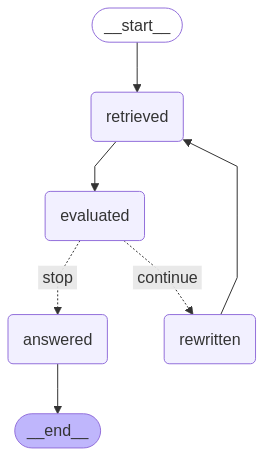

time: 578 ms (started: 2025-05-10 12:23:44 +09:00)


In [65]:
def create_ei_law_agent_graph(debug: bool = False) -> StateGraph:
    """Create the StateGraph for the Employment Insurance Law Retrieval Agent."""
    graph = StateGraph(state_schema=EmploymentInsuranceState)
    
    # Add nodes
    graph.add_node("retrieved", retrieve_documents)
    graph.add_node("evaluated", extract_and_evaluate_information)
    graph.add_node("rewritten", rewrite_query)
    graph.add_node("answered", generate_answer)
    
    # Add edges
    graph.add_edge(START, "retrieved")
    graph.add_edge("retrieved", "evaluated")
    
    graph.add_conditional_edges(
        source="evaluated",
        path=should_continue,
        path_map={
            "continue": "rewritten",
            "stop": "answered"
        }
    )
    
    graph.add_edge("rewritten", "retrieved")
    graph.add_edge("answered", END)
    
    compiled_graph = graph.compile()
    
    # Optional graph visualization
    if debug:
        from IPython.display import Image, display
        display(Image(compiled_graph.get_graph().draw_mermaid_png()))
        
    return compiled_graph

# Create the graph
ei_law_graph = create_ei_law_agent_graph(debug=True)


In [66]:
inputs = {"question": "실업급여를 받을 수 있는 조건이 있나요?"}

for chunk in ei_law_graph.stream(inputs):
    for key, value in chunk.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

[Employment Insurance RAG] Retrieving documents...
"Node 'retrieved':"
("Value: {'relevant_docs': [Document(metadata={'article': '제56조(지급일 및 지급 방법)', "
 "'chapter': '제4장 실업급여', 'name': '고용보험법', 'section': '제2절 구직급여', 'source': "
 "'../data\\\\고용보험법(법률)(제20519호)(20250223).pdf'}, page_content='[법률정보]\\n다음 "
 '조항은 고용보험법 제4장 실업급여 제2절 구직급여에서 발췌한 내용입니다.\\n\\n[법률조항]\\n제56조(지급일 및 지급 '
 '방법)\\n①구직급여는 대통령령으로 정하는 바에 따라 실업의 인정을 받은 일수분(日數分)을 지급한다.②직업안정기관의 장은 각 수급자격자에 '
 "대한 구직급여를 지급할 날짜를 정하여 당사자에게 알려야 한다.'), Document(metadata={'article': "
 "'제56조(지급일 및 지급 방법)', 'chapter': '제4장 실업급여', 'name': '고용보험법', 'section': '제2절 "
 "구직급여', 'source': '../data\\\\고용보험법(법률)(제20519호)(20250223).pdf'}, "
 "page_content='[법률정보]\\n다음 조항은 고용보험법 제4장 실업급여 제2절 구직급여에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제56조(지급일 및 지급 방법)\\n①구직급여는 대통령령으로 정하는 바에 따라 실업의 인정을 받은 '
 "일수분(日數分)을 지급한다.②직업안정기관의 장은 각 수급자격자에 대한 구직급여를 지급할 날짜를 정하여 당사자에게 알려야 한다.')]}")

----------------------------------------------------------

[Employment Insurance RAG] Extrac

In [53]:
print(value['refined_question'].content)

# 실업급여를 받을 수 있는 조건

실업급여를 받기 위해서는 몇 가지 조건을 충족해야 합니다. 구직급여는 실업의 인정을 받은 일수분을 지급받게 되며, 이는 고용보험법에 명시되어 있습니다.

## 관련 법률 조항

1. **실업의 인정**: 구직급여는 실업의 인정을 받은 일수분을 지급합니다. 이는 고용보험법 제4장 실업급여 제2절 구직급여 제56조에 명시되어 있습니다. (Source: 고용보험법 제4장 실업급여 제2절 구직급여 제56조)

## 추가 설명

실업급여를 받기 위해서는 다음과 같은 조건을 충족해야 합니다:

- **실업 상태**: 신청자는 고용이 종료된 상태여야 하며, 자발적으로 퇴사한 경우에는 특정 조건을 충족해야 합니다.
- **구직 활동**: 실업급여를 받기 위해서는 적극적으로 구직 활동을 해야 하며, 이를 증명할 수 있어야 합니다.
- **보험료 납부**: 신청자는 일정 기간 동안 고용보험료를 납부한 기록이 있어야 합니다.

이러한 조건들은 실업급여의 지급을 위한 기본적인 요건으로, 각 조건을 충족하지 못할 경우 실업급여를 받을 수 없습니다.

## 결론 및 요약

실업급여를 받기 위해서는 실업의 인정을 받아야 하며, 구직 활동을 하고, 고용보험료를 일정 기간 납부한 기록이 필요합니다. 이러한 조건들은 고용보험법에 명시되어 있으며, 이를 통해 실업급여의 지급이 이루어집니다. (Source: 고용보험법 제4장 실업급여 제2절 구직급여 제56조)
time: 15 ms (started: 2025-05-10 11:43:57 +09:00)
